In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision import models
from torch.utils.data import DataLoader


In [3]:
# Check if CUDA is available (GPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [4]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# Load CIFAR-10 dataset
cifar10_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
cifar10_loader = DataLoader(cifar10_dataset, batch_size=64, shuffle=True, num_workers=2)

100%|██████████| 170498071/170498071 [00:03<00:00, 43000666.86it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [5]:
class SimCLRModel(nn.Module):
    def __init__(self, base_encoder, projection_dim=128):
        super(SimCLRModel, self).__init__()
        self.encoder = base_encoder
        self.projection_dim = projection_dim

        # Get the output size of the base encoder dynamically
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 224, 224)  # Assumes input size of (3, 224, 224)
            encoder_output = self.encoder(dummy_input)
            self.feature_dim = encoder_output.size(-1)

        # Projection head
        self.projector = nn.Sequential(
            nn.Linear(self.feature_dim, 512),
            nn.ReLU(),
            nn.Linear(512, projection_dim)
        )

    def forward(self, x):
        features = self.encoder(x)
        projections = self.projector(features)
        return features, projections

In [6]:

# Define SimCLR-specific augmentations
simclr_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.5, 0.5, 0.5, 0.5),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:

# Initialize the base encoder (e.g., ResNet-18)
base_encoder = models.resnet18(weights=None)
base_encoder.fc = nn.Identity()
# Initialize the SimCLR model
simclr_model = SimCLRModel(base_encoder)
# Set up the loss function (contrastive loss)
criterion = nn.CrossEntropyLoss()
# Set up the optimizer (e.g., Adam)
optimizer = optim.Adam(simclr_model.parameters(), lr=0.001)

In [8]:

# Training loop for 50 epochs
num_epochs = 50

train_losses = []  # Store loss values for plotting
train_accuracies = []  # Store accuracy values for plotting

for epoch in range(num_epochs):
    simclr_model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for data in cifar10_loader:
        inputs, _ = data
        inputs = inputs.to(device)

        simclr_model.to(device)

        optimizer.zero_grad()

        # Generate positive and negative pairs
        features, projections = simclr_model(inputs)
        projections = projections / torch.norm(projections, dim=1, keepdim=True)

        # Compute similarity scores
        similarity_matrix = torch.matmul(projections, projections.t())
        batch_size = inputs.size(0)

        # Generate labels for contrastive loss
        labels = torch.arange(batch_size).to(device)
        logits = similarity_matrix / 0.07  # Temperature parameter (tune as needed)
        loss = criterion(logits, labels)

         # Calculate accuracy
        _, predicted = torch.max(logits, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate and store accuracy
    accuracy = 100 * correct_predictions / total_predictions
    train_accuracies.append(accuracy)

    # Print the average loss and accuracy for this epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}] Loss: {running_loss / len(cifar10_loader):.4f}, Accuracy: {accuracy:.2f}%')

    # Store the loss for plotting
    train_losses.append(running_loss / len(cifar10_loader))

print('Training finished')

Epoch [1/50] Loss: 0.0347, Accuracy: 100.00%
Epoch [2/50] Loss: 0.0049, Accuracy: 100.00%
Epoch [3/50] Loss: 0.0022, Accuracy: 100.00%
Epoch [4/50] Loss: 0.0032, Accuracy: 100.00%
Epoch [5/50] Loss: 0.0029, Accuracy: 100.00%
Epoch [6/50] Loss: 0.0017, Accuracy: 100.00%
Epoch [7/50] Loss: 0.0026, Accuracy: 100.00%
Epoch [8/50] Loss: 0.0011, Accuracy: 100.00%
Epoch [9/50] Loss: 0.0016, Accuracy: 100.00%
Epoch [10/50] Loss: 0.0010, Accuracy: 100.00%
Epoch [11/50] Loss: 0.0020, Accuracy: 100.00%
Epoch [12/50] Loss: 0.0012, Accuracy: 100.00%
Epoch [13/50] Loss: 0.0010, Accuracy: 100.00%
Epoch [14/50] Loss: 0.0008, Accuracy: 100.00%
Epoch [15/50] Loss: 0.0008, Accuracy: 100.00%
Epoch [16/50] Loss: 0.0011, Accuracy: 100.00%
Epoch [17/50] Loss: 0.0011, Accuracy: 100.00%
Epoch [18/50] Loss: 0.0007, Accuracy: 100.00%
Epoch [19/50] Loss: 0.0006, Accuracy: 100.00%
Epoch [20/50] Loss: 0.0007, Accuracy: 100.00%
Epoch [21/50] Loss: 0.0007, Accuracy: 100.00%
Epoch [22/50] Loss: 0.0008, Accuracy: 100.0

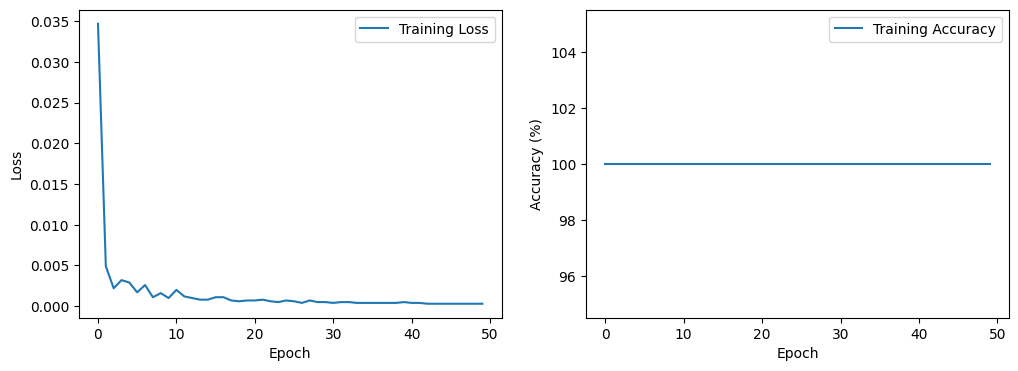

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()